In [5]:
import pickle as pkl
import glob
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
from collections import Counter

In [2]:
file = '../../data_scratch/train_env_task_set_20_full_reduced_tasks/6_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0.2v9_particles_v2/logs_episode.247_iter.0.pik'
with open(file, 'rb') as f:
    content = pkl.load(f)


In [3]:
content['goals']

{0: {'on_cupcake_136': 1,
  'on_juice_136': 1,
  'on_pancake_136': 0,
  'on_poundcake_136': 0,
  'on_wine_136': 0,
  'on_pudding_136': 0,
  'on_apple_136': 1,
  'on_coffeepot_136': 0},
 1: {'on_cupcake_136': 1,
  'on_juice_136': 1,
  'on_pancake_136': 0,
  'on_poundcake_136': 0,
  'on_wine_136': 0,
  'on_pudding_136': 0,
  'on_apple_136': 1,
  'on_coffeepot_136': 0}}

In [6]:
ls ../../data_scratch/large_data

logging/
test_env_task_set_10_full_reduced_tasks/
test_env_task_set_10_full_reduced_tasks_single/
train_env_task_set_20_full_reduced_tasks/
train_env_task_set_20_full_reduced_tasks_single/


In [8]:
# data_folder = '../../data_scratch/train_env_task_set_20_full_reduced_tasks/'
#data_folder = '../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks/'
data_folder = '../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/'
data_folder_test = '../../data_scratch/large_data/test_env_task_set_10_full_reduced_tasks_single/'


In [9]:
def get_info_file(file_name):
    with open(file_name, 'rb') as f:
        aux = pkl.load(f)
    
    if 'action' not in aux:
        print('error in', file_name)
        return {}
    num_goal_finished = sum([len(val) for key, val in aux['goals_finished'][-1].items()])
    num_goal_total = sum([val for key, val in aux['goals'][0].items()])

    length_action = len(aux['action'][0])
    data_info = {
        'length': length_action,
        'script': aux['action'],
        'finished': num_goal_finished,
        'total': num_goal_total
    }
    return data_info

def is_success(elem):
    return elem['finished'] == elem['total']

In [10]:
def get_info_agents(data_folder):
    agents = glob.glob('{}/*'.format(data_folder))
    agent_files = {}
    all_files = []
    for agent in agents:
        agent_name = agent.split('/')[-1]
        if agent_name[0] == 'o':
            continue
        files = [fn for fn in glob.glob('{}/*'.format(agent)) if 'results' not in fn.split('/')[-1] ]
        agent_files[agent_name] = files
        all_files += files


    print(len(all_files))

    

    data_info = {}
    with Pool(40) as p:
        info = p.map(get_info_file, all_files)
        for file_name, info_item in zip(all_files, info):
            data_info[file_name] = info_item
            
    return agent_files, data_info  

In [11]:
def plot_info_agents(agent_files, data_info):
    agent_ids = sorted([int(agentf.split('_')[0].replace('old', ''))-1 for agentf in agent_files if agentf[0]])
    ep_gen = []
    for agent_name in sorted(agent_files.keys()):
        print(agent_name, len(agent_files[agent_name]))
        ep_gen.append(len(agent_files[agent_name]))
    fig, ax = plt.subplots()
    ax.bar(range(len(agent_ids)), ep_gen)
    ax.set_title("Episodes generated")
    ax.set_xticks(range(len(agent_ids)))
    ax.set_xticklabels(agent_ids)
    


def plot_trajectory_stats(agent_files, data_info):
    agent_ids = sorted([int(agentf.split('_')[0].replace('old', ''))-1 for agentf in agent_files if agentf[0]])

    keys = ['[walktowards]', '[open]', '[grab]', '[putback]', '[putin]']
    action_dict = {action: item for item, action in enumerate(keys)}
    nbins = 20

    success_all = []
    total_files = []
    success_mean = []
    length_mean, length_error = [], []
    action_count = []
    all_bins = []
    for agent in sorted(agent_files, key=lambda x: x.replace('old', '')):

        bins = np.zeros((len(keys), nbins))
        files = agent_files[agent]
        error_found = False
        actions_all = []
        for file in files:
            if file not in data_info:
                continue
            try:
                script = data_info[file]['script'][0]
            except:
                print(file)
            current_actions = [x.split(' ')[0].replace('>', '').replace('<', '') for x in script]
            current_action_ids = [action_dict[ca] for ca in current_actions]
            for it, cactid in enumerate(current_action_ids):
                size_bin = len(current_action_ids)/nbins
                index_bin = int(it / size_bin)
                bins[cactid, index_bin] += 1

            actions_all += current_actions

            if not is_success(data_info[file]):
                print(file)
                #for scr in script:
                #   print(scr)
                print('---')
                break
        action_count.append(Counter(actions_all))
        success = [is_success(data_info[file]) for file in files if file in data_info]
        lengths = [data_info[file]['length'] for file in files if file in data_info]
        print('{:80s} {:04d} {:.02f} {:.02f}'.format(agent, len(files), np.mean(success), np.mean(lengths)))
        success_all += success
        success_mean.append(np.mean(success))
        length_mean.append(np.mean(lengths))
        length_error.append(np.std(lengths)/np.sqrt(len(lengths)))
        all_bins.append(bins)
        
    fig, ax = plt.subplots()
    ax.bar(range(len(agent_ids)), success_mean)
    ax.set_title("Success Rate")
    ax.set_xticks(range(len(agent_ids)))
    ax.set_xticklabels(agent_ids)

    fig, ax = plt.subplots()
    try:
        ax.bar(range(len(agent_ids)), length_mean, yerr=length_error)
    except:
        print(agent_ids, length_mean)
    ax.set_title("Average Length")
    ax.set_xticks(range(len(agent_ids)))
    ax.set_xticklabels(agent_ids)

    keys = ['[walktowards]', '[open]', '[grab]', '[putback]', '[putin]']
    fig, axes = plt.subplots(1, int((1+len(action_count))), figsize=(15,2))
    print(agent_ids)
    # axes = list(axes[0]) + list(axes[1])
    for it, act in enumerate(action_count):
        values = [act[x] for x in keys]
        axes[it].pie(values)
        axes[it].set_title(agent_ids[it])
    fig.delaxes(axes[-1])

    # plt.subplot(2, (1+len(action_count))/2, len(action_count)+1)
    fig.legend(keys, loc="center right")

    for cbinid, cbin in enumerate(all_bins):
        norm_bin = cbin/cbin.sum(0)
        plt.figure(figsize=(4,4))
        for iti in range(cbin.shape[0]):
            if iti == cbin.shape[0] - 1:
                base = norm_bin[iti,:]*0
            else:
                base = norm_bin[(iti+1):,:].sum(0)
            plt.bar(range(cbin.shape[1]), norm_bin[iti,:]+base, width=1.0)
            plt.title(agent_ids[cbinid])

In [14]:
agent_files, data_info = get_info_agents(data_folder)

10200


1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2 3014
2_full_opencost0.5_closecostFalse_walkcost0.01_forgetrate0v9_particles_v2 2143
3_full_opencost-5_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2 2148
4_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2 2895
1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2          3014 1.00 10.53
2_full_opencost0.5_closecostFalse_walkcost0.01_forgetrate0v9_particles_v2        2143 1.00 10.92
3_full_opencost-5_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2         2148 1.00 12.84
../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/4_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2/logs_episode.282_iter.0.pik
---
4_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2       2895 1.00 22.24
[0, 1, 2, 3]


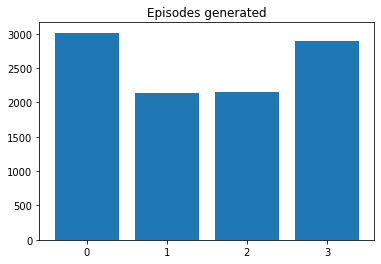

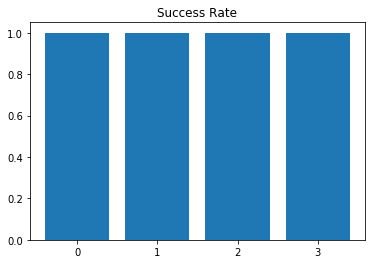

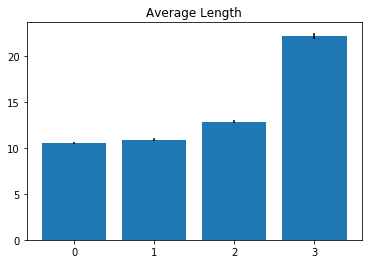

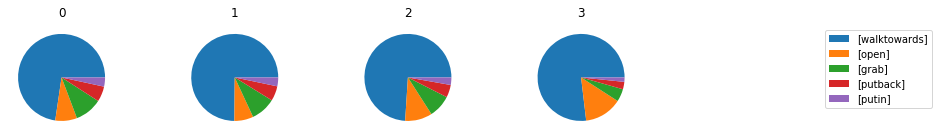

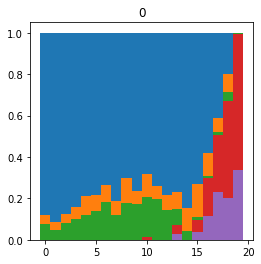

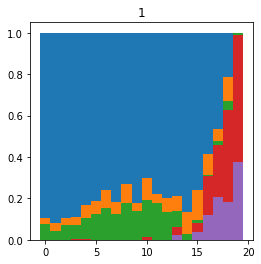

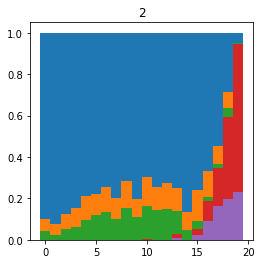

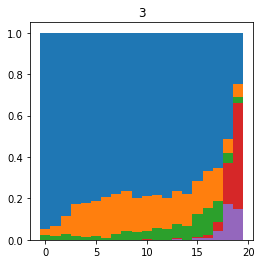

In [15]:

plot_info_agents(agent_files, data_info)
plot_trajectory_stats(agent_files, data_info)

300
1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2 300
1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2          0300 1.00 11.03
[0]


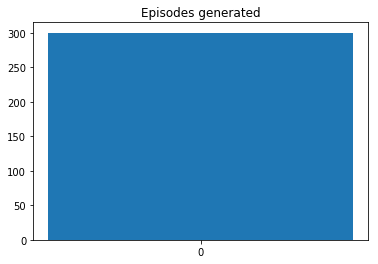

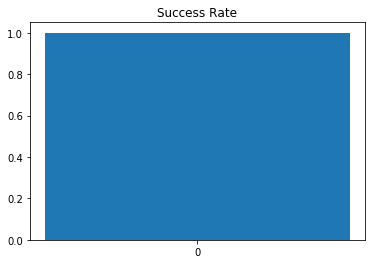

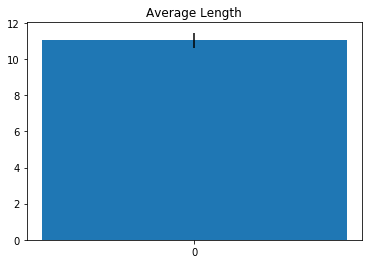

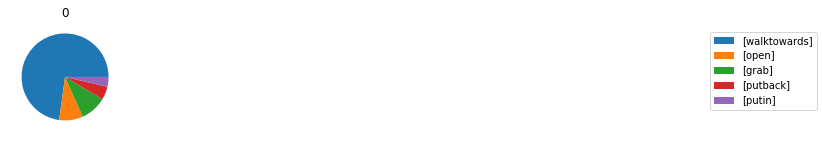

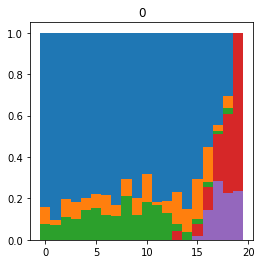

In [44]:
agent_files, data_info = get_info_agents(data_folder_test)
plot_info_agents(agent_files, data_info)
plot_trajectory_stats(agent_files, data_info)

! rm../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/3_full_opencost-5_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2/results_0.pik ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2/results_0.pik

In [ ]:
data_folder = '../../data_scratch/large_data/test_env_task_set_10_full_reduced_tasks/'


In [ ]:
agent_files, data_info = get_info_agents(data_folder)
plot_info_agents(agent_files, data_info)
plot_trajectory_stats(agent_files, data_info)

In [18]:
rmdir ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/4_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2

In [ ]:
! rm ../../data_scratch/large_data/test_env_task_set_10_full_reduced_tasks/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2/results_0.pik

In [ ]:
! rm ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/3_full_opencost-5_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2/results_0.pik


In [ ]:
! rm ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2/results_0.pik

In [ ]:

print(np.mean(success_all))

In [ ]:
sorted(agent_files)

In [ ]:
agent_ids = sorted([int(agentf.split('_')[0].replace('old', ''))-1 for agentf in agent_files])
fig, ax = plt.subplots()
ax.bar(range(len(agent_ids)), success_mean)
ax.set_title("Success Rate")
ax.set_xticks(range(len(agent_ids)))
ax.set_xticklabels(agent_ids)

In [14]:
agent_ids

[0, 1, 2, 3, 5, 6, 7]

[Text(0, 0, '0')]

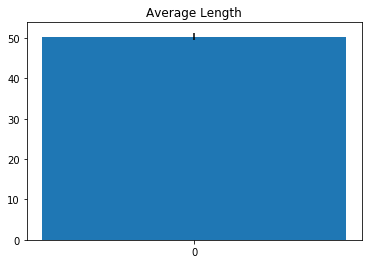

In [71]:
# agent_ids = sorted([agentf.split('_')[0] for agentf in agent_files])
fig, ax = plt.subplots()

ax.bar(range(len(agent_ids)), length_mean, yerr=length_error)
ax.set_title("Average Length")
ax.set_xticks(range(len(agent_ids)))
ax.set_xticklabels(agent_ids)

[0]


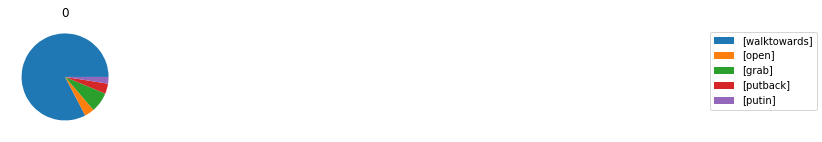

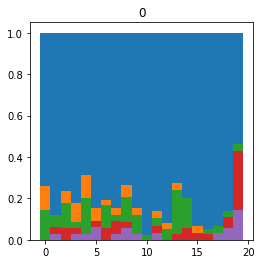

In [369]:
(1+len(action_count))/2

4.5

In [81]:
act.keys()

dict_keys(['[open]', '[walktowards]', '[grab]', '[putback]', '[putin]'])

In [108]:
aux['graph'][0]['nodes']

[{'id': 1,
  'category': 'Characters',
  'class_name': 'character',
  'bounding_box': {'center': [-1.56170034, 0.9229192, 2.80007076],
   'size': [0.722174644, 1.81389093, 0.957253456]},
  'states': []},
 {'id': 11,
  'category': 'Rooms',
  'class_name': 'kitchen',
  'bounding_box': {'center': [-3.75, 1.25, 3.75], 'size': [8.0, 3.0, 10.5]},
  'states': []},
 {'id': 12,
  'category': 'Walls',
  'class_name': 'wall',
  'bounding_box': {'center': [-7.47, 1.24999988, 2.49999523],
   'size': [0.06000071, 2.50000882, 2.50000954]},
  'states': []},
 {'id': 13,
  'category': 'Walls',
  'class_name': 'wall',
  'bounding_box': {'center': [-3.74999547, 1.24999571, -1.22000134],
   'size': [2.50001049, 2.50000954, 0.0600039065]},
  'states': []},
 {'id': 14,
  'category': 'Walls',
  'class_name': 'wall',
  'bounding_box': {'center': [-3.75000882, 1.24999344, 8.720001],
   'size': [2.500019, 2.50002646, 0.0599974133]},
  'states': []},
 {'id': 15,
  'category': 'Walls',
  'class_name': 'wall',
  'b

In [21]:
data_info['../../data_scratch/train_env_task_set_20_full_reduced_tasks/6_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0.2v9_particles_v2/logs_episode.305_iter.0.pik'].keys()

dict_keys(['length', 'script', 'finished', 'total'])

In [38]:
import ipdb
total, cont = 0, 0
for prog in agent_files['1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2']:
    script = data_info[prog]['script'][0]
    grab = len([x for x in script if 'grab' in x])
    put = len([x for x in script if 'put' in x])
    if grab != put:
        cont += 1
#         for p in script:
#             print(p)
#         ipdb.set_trace()
    total += 1

In [23]:
script = data_info[prog]['script']

In [102]:
data_info[list(data_info.keys())[0]]

{'length': 41,
 'script': {0: ['[walktowards] <kitchencabinet> (137)',
   '[walktowards] <kitchencabinet> (137)',
   '[walktowards] <kitchencabinet> (137)',
   '[walktowards] <kitchencabinet> (137)',
   '[walktowards] <kitchencabinet> (137)',
   '[walktowards] <kitchencabinet> (137)',
   '[walktowards] <kitchencabinet> (137)',
   '[open] <kitchencabinet> (137)',
   '[grab] <cutleryfork> (388)',
   '[grab] <cutleryfork> (386)',
   '[walktowards] <kitchentable> (132)',
   '[walktowards] <kitchentable> (132)',
   '[putback] <cutleryfork> (388) <kitchentable> (132)',
   '[walktowards] <kitchencabinet> (139)',
   '[walktowards] <kitchencabinet> (139)',
   '[walktowards] <kitchencabinet> (139)',
   '[walktowards] <kitchencabinet> (139)',
   '[open] <kitchencabinet> (139)',
   '[walktowards] <kitchentable> (132)',
   '[walktowards] <kitchentable> (132)',
   '[walktowards] <cutleryfork> (387)',
   '[walktowards] <kitchentable> (132)',
   '[walktowards] <kitchentable> (132)',
   '[walktowards] 

In [40]:
total

316

In [26]:
import pickle as pkl
with open('../dataset/test_env_task_set_10_full_reduced_tasks_single.pik', 'rb') as f:
    init_dataset = pkl.load(f)


In [90]:
for it, file in enumerate(init_dataset):
    goal = [x for x, y in file['task_goal'][0].items() if y > 0][0]
    goal_name = goal.split('_')[1]
    locs = []
    id2node = {node['id']: node for node in file['init_graph']['nodes']}
    dict_goal = {}
    for node in file['init_graph']['nodes']:
        if node['class_name'] == goal_name:
            dict_goal[node['id']] = ['', '', '']
    for edge in file['init_graph']['edges']:
        if edge['relation_type'].lower() not in  ['facing', 'close'] and edge['from_id'] in dict_goal:
            to_id = edge['to_id']
            from_id = edge['from_id']
            if id2node[to_id]['category'] == 'Rooms':
                dict_goal[from_id][1] = id2node[to_id]['class_name']
            else:
                dict_goal[from_id][0] = id2node[to_id]['class_name']
                dict_goal[from_id][2] = edge['relation_type']
    
    init_room = file['init_rooms'][0]
    locations = ', '.join(['{} {} ()'.format(gv[2], gv[0], gv[1]) for gv in dict_goal.values()])
    print('File {}. Init Room: {}. Goal {}: {}'.format(it, init_room, goal_name, locations))
#     print('-----')

File 0. Init Room: livingroom. Goal wineglass: INSIDE kitchencabinet (), INSIDE cabinet ()
File 1. Init Room: bathroom. Goal waterglass: ON coffeetable ()
File 2. Init Room: kitchen. Goal waterglass: INSIDE kitchencabinet ()
File 3. Init Room: kitchen. Goal plate: ON kitchencounter (), ON sink (), ON kitchencounter ()
File 4. Init Room: kitchen. Goal cutleryfork: ON kitchencounter (), INSIDE kitchencabinet (), INSIDE kitchencabinet ()
File 5. Init Room: kitchen. Goal cutleryfork: INSIDE kitchencabinet (), INSIDE kitchencabinet ()
File 6. Init Room: bathroom. Goal waterglass: INSIDE cabinet ()
File 7. Init Room: livingroom. Goal waterglass: ON kitchencounter (), ON kitchencounter ()
File 8. Init Room: kitchen. Goal cutleryfork:   (), ON kitchencounter (),   ()
File 9. Init Room: bathroom. Goal waterglass: INSIDE cabinet ()
File 10. Init Room: kitchen. Goal waterglass: ON kitchencounter (), ON coffeetable ()
File 11. Init Room: bathroom. Goal wineglass: INSIDE dishwasher (), INSIDE dishw

In [79]:
[node for node in file['init_graph']['nodes'] if node['class_name'] == 'kitchen']

[{'id': 58,
  'category': 'Rooms',
  'class_name': 'kitchen',
  'prefab_name': 'PRE_ROO_Kitchen_02',
  'obj_transform': {'position': [-3.75, 0.0, 6.25],
   'rotation': [0.0, -0.7071068, 0.0, 0.7071067]},
  'bounding_box': {'center': [-6.249999, 1.25, 2.5], 'size': [8.0, 3.0, 8.0]},
  'properties': [],
  'states': []}]

In [50]:
ls ../../data_scratch/large_data_toy/test_env_task_set_10_full_reduced_tasks_single/*

logs_episode.73_iter.0.pik  logs_episode.78_iter.0.pik


In [111]:
import glob
import os
def read_file(file_name):
    with open(file_name, 'rb') as f:
        content = pkl.load(f)
    print(len(content['obs']), len(content['action'][0]))
    return '\n'.join(content['action'][0])

root_dir = '../../data_scratch/large_data_toy/test_env_task_set_10_full_reduced_tasks/'
files = ['logs_episode.2_iter.0.pik', 'logs_episode.91_iter.0.pik', 'logs_episode.20_iter.0.pik'] # User for second example
files = ['logs_episode.0_iter.0.pik'] # User for first example
agents = glob.glob('{}/*'.format(root_dir))
for agent in sorted(agents):
    file_name = '{}/{}'.format(agent, files[0])
    if os.path.isfile(file_name):
        content = read_file(file_name)
        print(agent)
        print(content)
    

38 37
../../data_scratch/large_data_toy/test_env_task_set_10_full_reduced_tasks/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2
[walktowards] <plate> (374)
[walktowards] <plate> (374)
[walktowards] <plate> (374)
[grab] <plate> (374)
[walktowards] <bedroom> (210)
[walktowards] <bedroom> (210)
[walktowards] <bedroom> (210)
[walktowards] <bedroom> (210)
[walktowards] <bedroom> (210)
[walktowards] <bedroom> (210)
[open] <cabinet> (216)
[grab] <plate> (372)
[walktowards] <kitchen> (11)
[walktowards] <kitchen> (11)
[walktowards] <kitchen> (11)
[walktowards] <kitchen> (11)
[walktowards] <kitchentable> (72)
[walktowards] <kitchentable> (72)
[walktowards] <kitchentable> (72)
[putback] <plate> (372) <kitchentable> (72)
[putback] <plate> (374) <kitchentable> (72)
[walktowards] <kitchencabinet> (77)
[walktowards] <kitchencabinet> (77)
[walktowards] <kitchencabinet> (77)
[open] <kitchencabinet> (77)
[grab] <wineglass> (369)
[walktowards] <cutleryfork> (370)
[walktowards] <cu

In [103]:
! rm -rf ../../data_scratch/large_data_toy/test_env_task_set_10_full_reduced_tasks_single/7_partial_opencost-500_closecostFalse_walkcost0.01_forgetrate0.01v9_particles_v2